In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo Específico
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix, precision_recall_curve)

# Balanceo
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.tree import export_text

In [305]:
# CONFIGURACIÓN
SEED = 42
DATA_DIR = 'Data/' # Ajusta si tus archivos están en otra carpeta

# Umbral de decisión (Ajustable: > 0.5 para más precisión, < 0.5 para más recall)
UMBRAL_CORTE = 0.6752

pd.set_option('display.max_columns', None)

# Configuración Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [306]:
# Archivos

MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'


In [307]:
# Parámetros base para Random Forest
PARAMS_ESTATICOS = {
    'GENERAL': {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CL':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 400
    },
    'PE':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CO':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'AR':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 400
    }
}
PARAMS_OPTIMIZADOS = {
    'GENERAL': {'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10},
    'CL': {'class_weight': 'balanced', 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2},
    'PE': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 11},
    'CO': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 6},
    'AR': {'class_weight': 'balanced', 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1}
}

In [308]:
def matriz_correlacion(pack_modelo, X, feature_names=None, top_n=37):
    model = pack_modelo['model']

    # 1. Obtener importancias (RandomForest)
    importancias = getattr(model, "feature_importances_", None)
    if importancias is None:
        raise ValueError("El modelo no tiene 'feature_importances_'. Asegúrate de pasar un RandomForest entrenado.")

    # 2. Crear DataFrame de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        if feature_names is None:
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 3. Selección top_n (o todas si top_n es None)
    if top_n is None or top_n >= df_X.shape[1]:
        cols_top = list(df_X.columns)
    else:
        # manejar posible desajuste de tamaño
        n_feats = min(len(importancias), df_X.shape[1])
        importancias = importancias[:n_feats]
        indices_top = np.argsort(importancias)[::-1][:top_n]
        cols_top = [df_X.columns[i] for i in indices_top]

    df_top = df_X[cols_top]

    # 4. Calcular Correlación (Pearson)
    corr = df_top.corr()

    # 5. Graficar
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={'shrink': .8}, annot_kws={'size':8})
    plt.title(f"Matriz de Correlación (Top {len(cols_top)} Variables)")
    plt.tight_layout()
    plt.show()

    return corr


In [309]:
def entrenar_rf_visual(X_train, X_test, y_train, y_test, nombre_modelo, params):

    print(f"PROCESANDO RANDOM FOREST: {nombre_modelo}")
    print(f"{'='*60}")

    # 1. Separar parámetros del modelo de los nuestros
    rf_params = {k: v for k, v in params.items() if k != 'usar_smote' and k != 'threshold'}

    # 2. Aplicar SMOTE (Balanceo)
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE (Balanceo Sintético)...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 3. Entrenar Modelo
    print(f"-> Entrenando bosque con {rf_params.get('n_estimators', '??')} árboles...")
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_final, y_train_final)

    # 4. Predicciones (Probabilidades)
    probs_test = model.predict_proba(X_test)[:, 1]

    # USAR UMBRAL FIJO (sin optimización automática)
    mejor_umbral = params.get('threshold', UMBRAL_CORTE)
    preds = (probs_test >= mejor_umbral).astype(int)

    # 5. Métricas y Reportes
    auc = roc_auc_score(y_test, probs_test)

    print(f"\nREPORTE FINAL ({nombre_modelo})")
    print(classification_report(y_test, preds, target_names=['Ocio', 'Trabajo']))
    print(f"AUC-ROC Score: {auc:.4f}")

    # 6. Gráficos
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Ocio', 'Trabajo']).plot(ax=ax[0], cmap='Greens')
    ax[0].set_title(f"Matriz de Confusión (Corte: {mejor_umbral:.2f})")
    ax[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title("Curva ROC")

    plt.tight_layout()
    plt.show()

    return {'model': model}

In [310]:
def graficar_importancia_rf(pack_modelo, feature_names, top_n=15):

    model = pack_modelo['model']
    importancias = model.feature_importances_

    df_imp = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False).head(top_n)
    # df_imp.copy().to_csv(f'Data/ChileRF.csv', index=False, sep=';')

    vals = df_imp['Importancia'].values
    if vals.max() - vals.min() > 0:
        norm = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        norm = np.zeros_like(vals)

    # Uso de la API recomendada: plt.get_cmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm)

    fig, ax = plt.subplots(figsize=(16, 10))
    y_pos = np.arange(len(df_imp))
    bars = ax.barh(y_pos, df_imp['Importancia'].values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_imp['Variable'].values)
    ax.invert_yaxis()
    ax.set_xlabel("Importancia Relativa (0 a 1)")
    ax.set_title("Importancia de Variables (Random Forest - Gini)")

    # Intentar usar bar_label (más limpio). Si no existe, usar texto manual.
    try:
        ax.bar_label(bars, fmt='%.4f', padding=6)
    except Exception:
        max_width = df_imp['Importancia'].max() if len(df_imp) else 1.0
        x_offset = max_width * 0.01  # pequeño espacio a la derecha de la barra
        for bar in bars:
            w = bar.get_width()
            ax.text(w + x_offset, bar.get_y() + bar.get_height() / 2, f'{w:.3f}',
                    va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()


PROCESANDO RANDOM FOREST: RF_General
-> Entrenando bosque con 500 árboles...

REPORTE FINAL (RF_General)
              precision    recall  f1-score   support

        Ocio       0.81      0.94      0.87      2274
     Trabajo       0.65      0.35      0.45       769

    accuracy                           0.79      3043
   macro avg       0.73      0.64      0.66      3043
weighted avg       0.77      0.79      0.76      3043

AUC-ROC Score: 0.7863


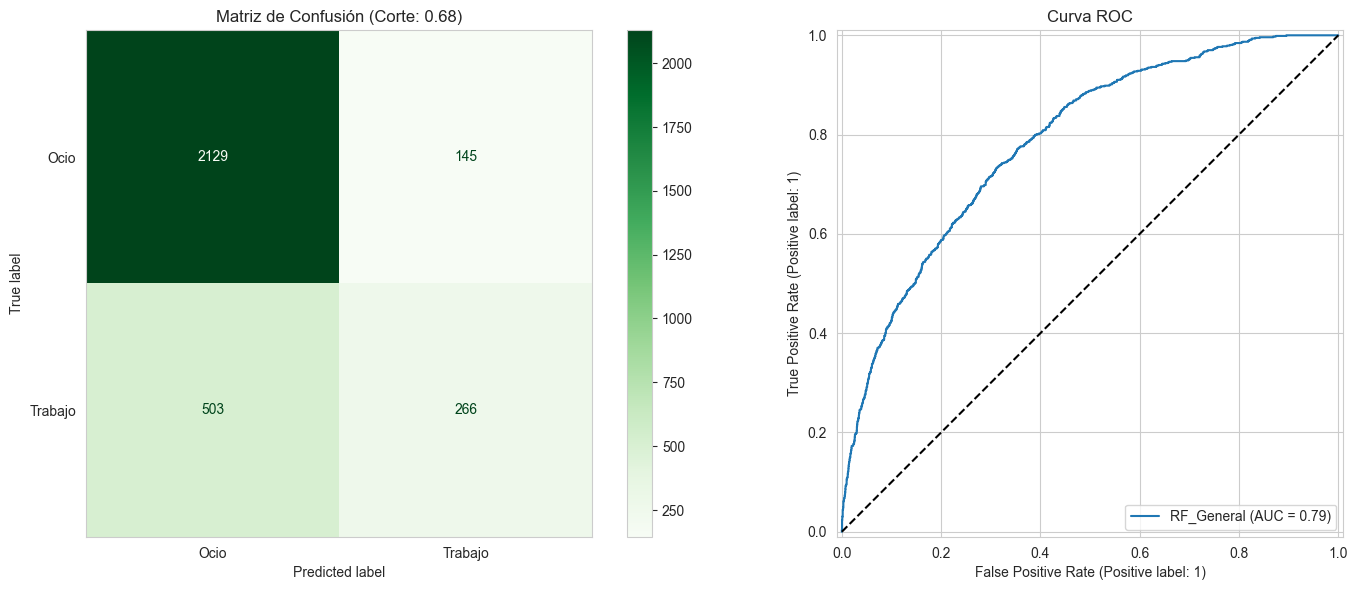

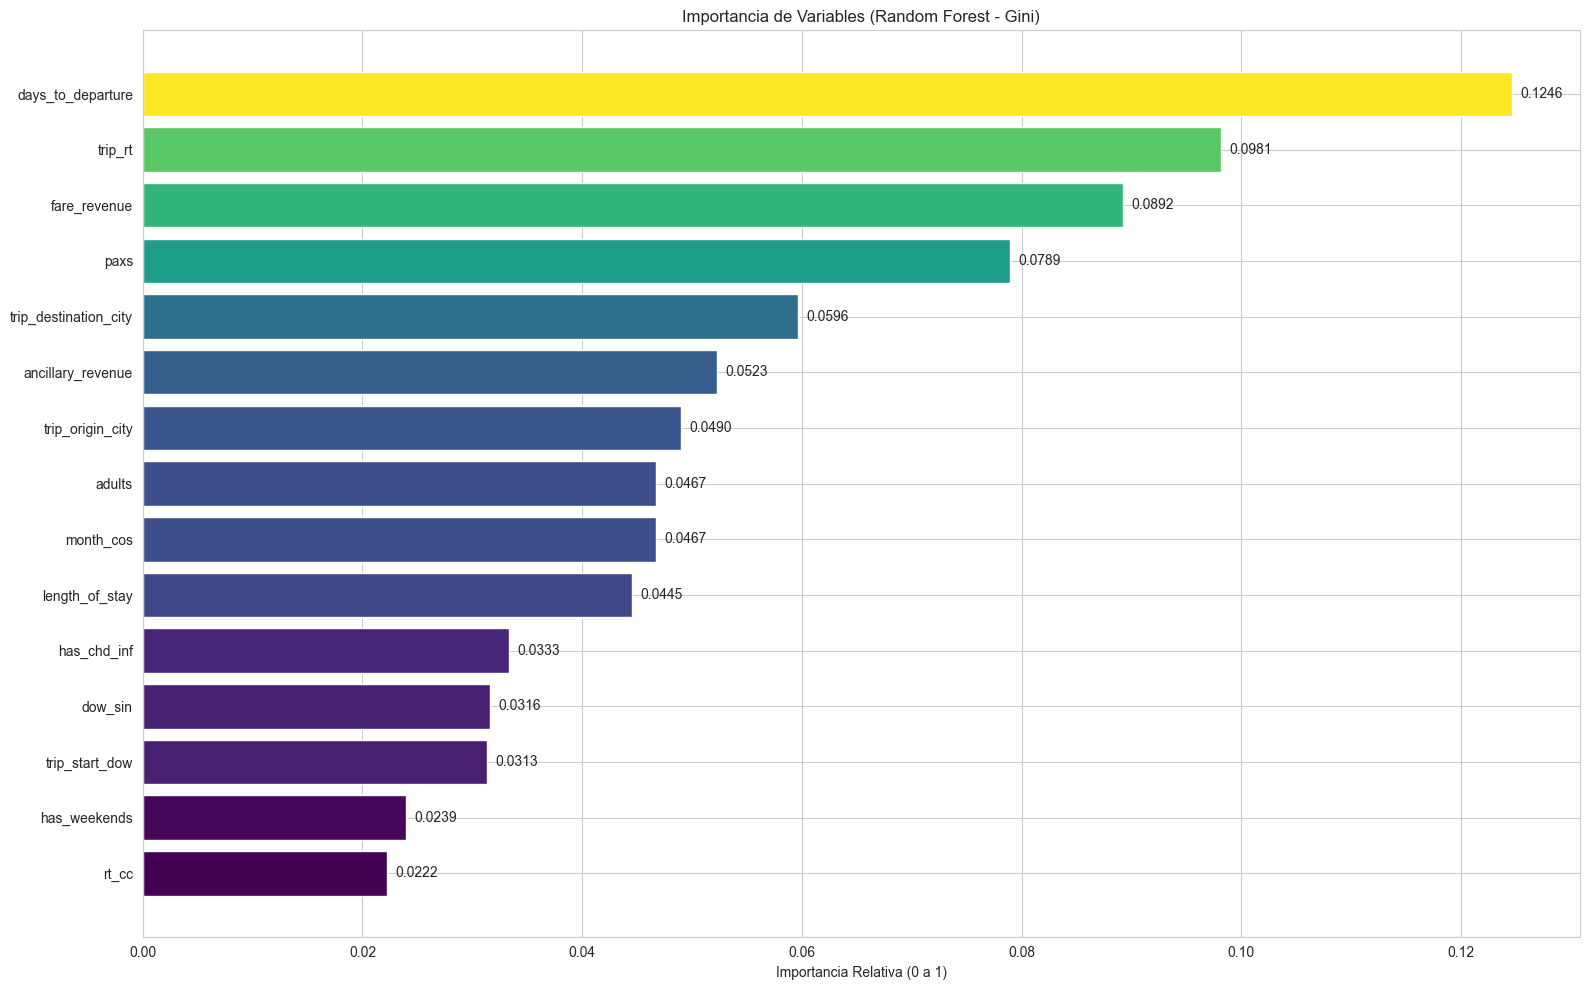

In [311]:
modelo = 'General'

X_train = pd.read_parquet(f'{DATA_DIR}X_train_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{modelo}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{modelo}.pkl')

# Entrenar
pack_rf_general = entrenar_rf_visual(
    X_train, X_test, y_train, y_test, 'RF_General', PARAMS_ESTATICOS['GENERAL']
)

# Graficar Importancia
graficar_importancia_rf(pack_rf_general, X_train.columns)

Cargando Chile...
PROCESANDO RANDOM FOREST: RF_Chile
-> Entrenando bosque con 400 árboles...

REPORTE FINAL (RF_Chile)
              precision    recall  f1-score   support

        Ocio       0.78      0.92      0.84       298
     Trabajo       0.78      0.50      0.61       159

    accuracy                           0.78       457
   macro avg       0.78      0.71      0.73       457
weighted avg       0.78      0.78      0.76       457

AUC-ROC Score: 0.8641


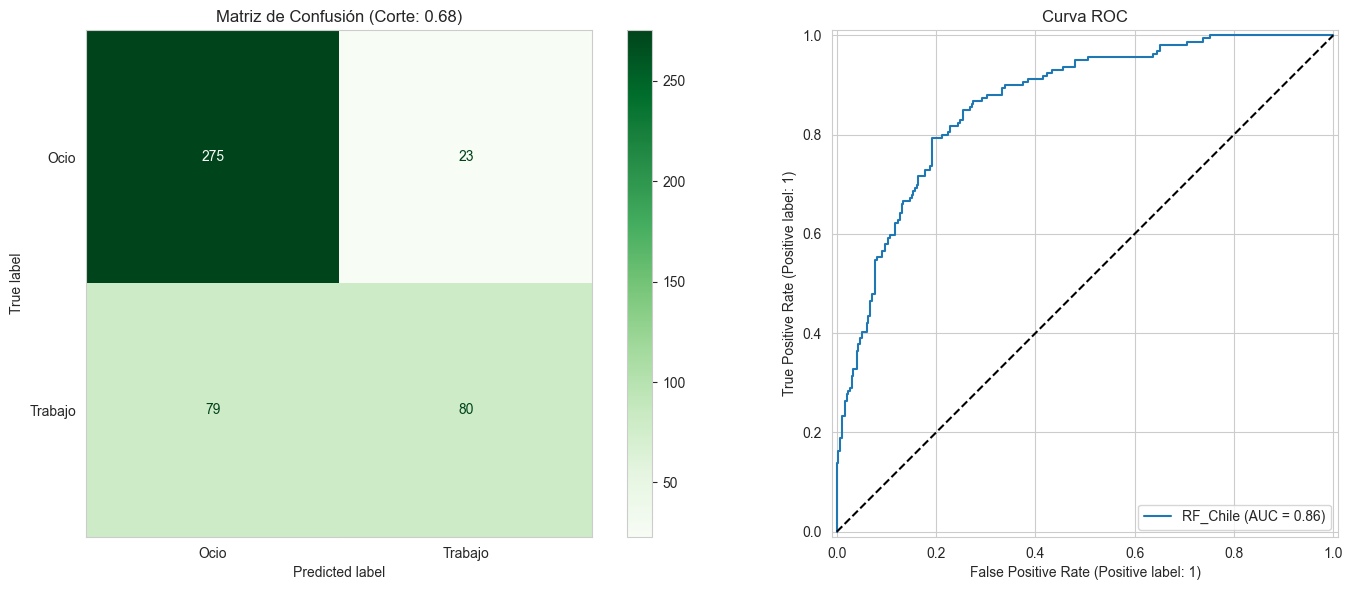

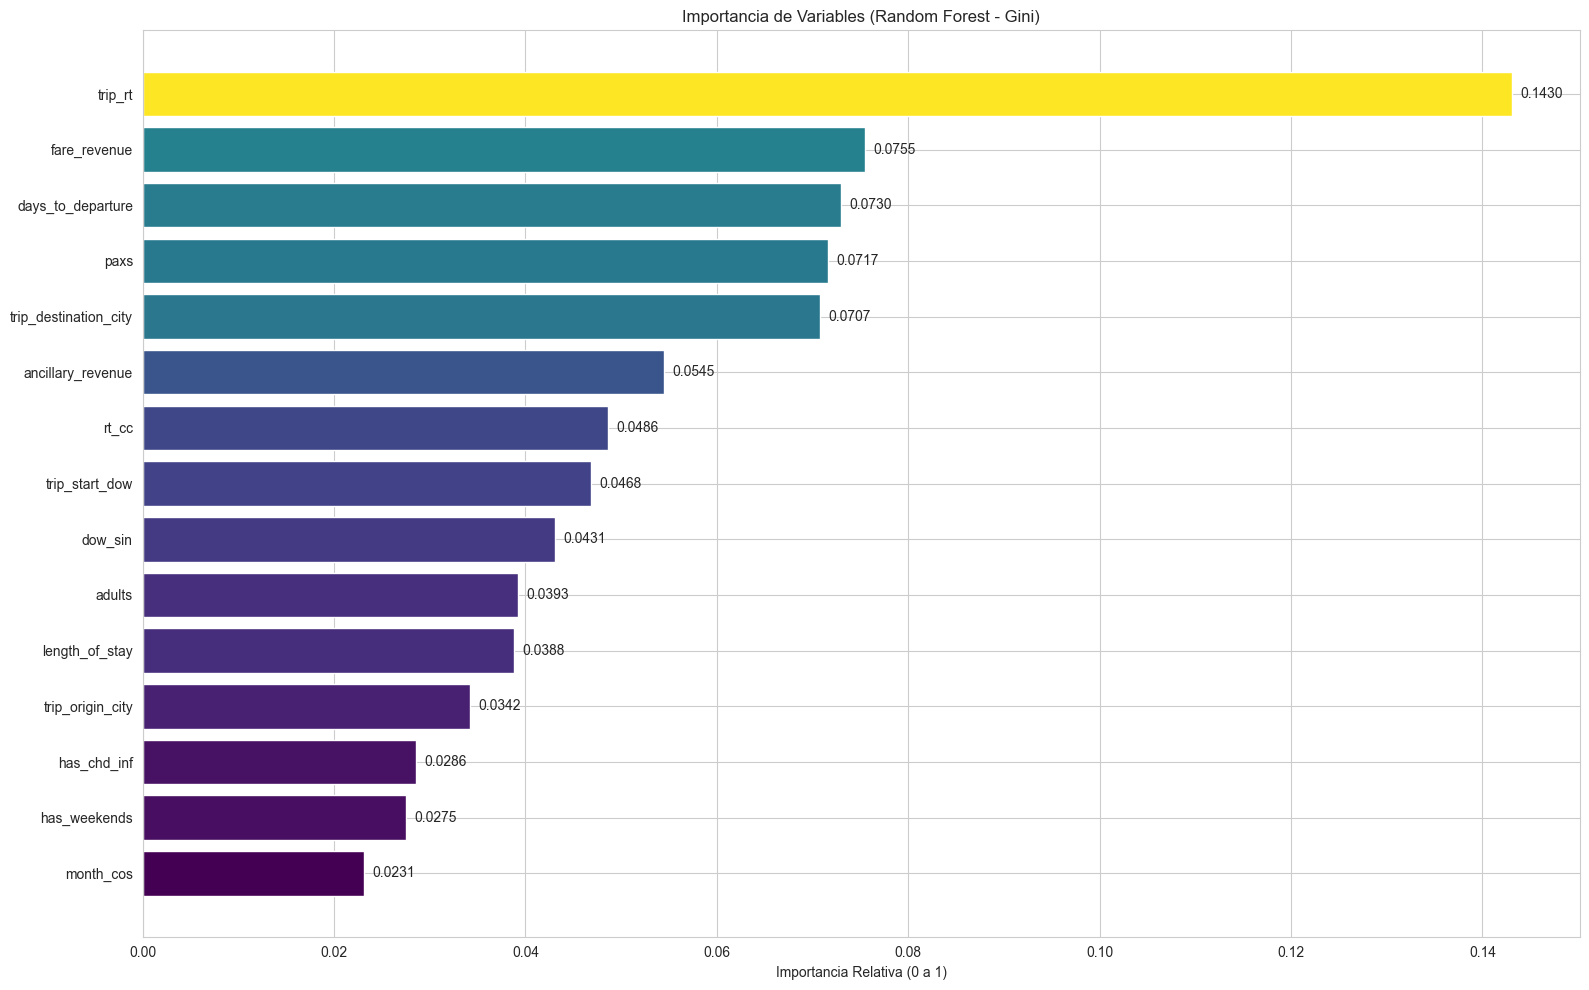

In [312]:
print("Cargando Chile...")
# Asegúrate que el nombre del archivo coincida con lo generado en el 01
X_train = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')



pack_rf_cl = entrenar_rf_visual(
    X_train, X_test, y_train, y_test,
    "RF_Chile", PARAMS_ESTATICOS['CL']
)

graficar_importancia_rf(pack_rf_cl, X_train.columns)


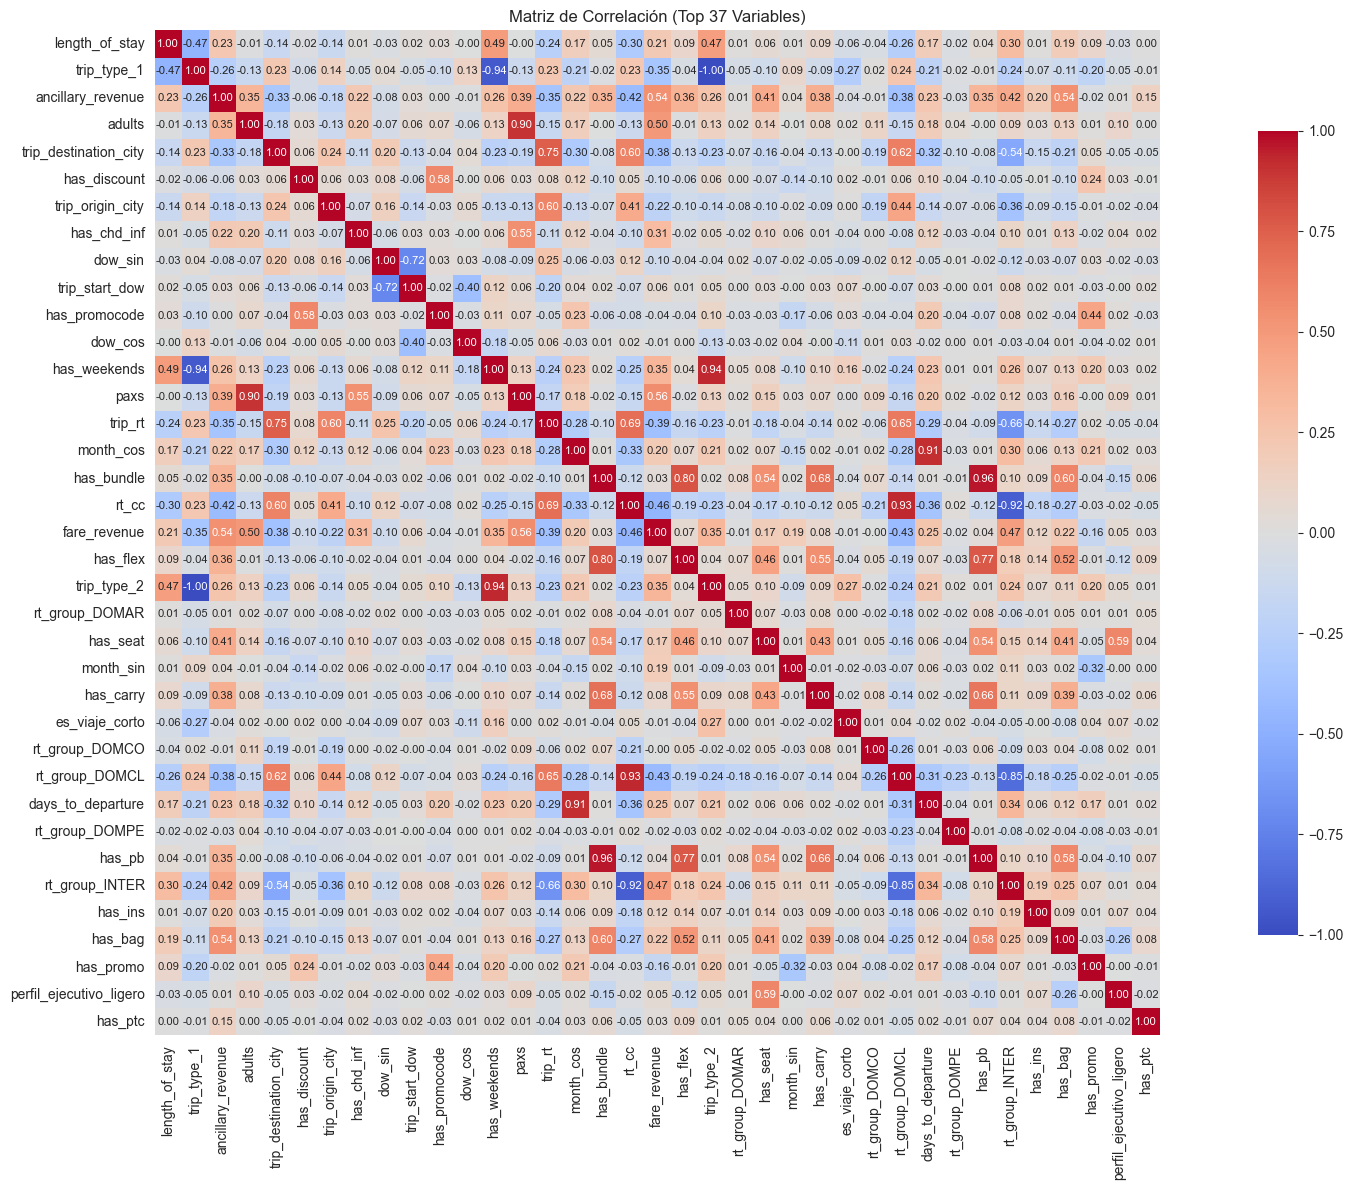

,length_of_stay,trip_type_1,ancillary_revenue,adults,trip_destination_city,has_discount,trip_origin_city,has_chd_inf,dow_sin,trip_start_dow,has_promocode,dow_cos,has_weekends,paxs,trip_rt,month_cos,has_bundle,rt_cc,fare_revenue,has_flex,trip_type_2,rt_group_DOMAR,has_seat,month_sin,has_carry,es_viaje_corto,rt_group_DOMCO,rt_group_DOMCL,days_to_departure,rt_group_DOMPE,has_pb,rt_group_INTER,has_ins,has_bag,has_promo,perfil_ejecutivo_ligero,has_ptc
length_of_stay,1.000000,-0.470655,0.231454,-0.008226,-0.144954,-0.019638,-0.139372,0.012037,-0.026492,0.020404,0.032993,-0.003458,0.488764,-0.001164,-0.244693,0.169281,0.049229,-0.297579,0.212625,0.094778,0.470655,0.014262,0.057095,0.011862,0.085703,-0.055336,-0.041129,-0.260546,0.174993,-0.023835,0.042507,0.302217,0.011476,0.190872,0.094785,-0.033675,0.001696
trip_type_1,-0.470655,1.000000,-0.255485,-0.134292,0.225079,-0.064263,0.136491,-0.051998,0.041628,-0.052691,-0.103086,0.125973,-0.936311,-0.127275,0.227212,-0.213391,-0.017423,0.230322,-0.349637,-0.043974,-1.000000,-0.054876,-0.101464,0.090851,-0.091713,-0.269498,0.015606,0.235568,-0.213180,-0.023047,-0.010189,-0.237717,-0.073131,-0.113846,-0.199309,-0.052656,-0.010887
ancillary_revenue,0.231454,-0.255485,1.000000,0.347616,-0.327302,-0.062599,-0.180767,0.217835,-0.076096,0.034415,0.003353,-0.011407,0.260071,0.390745,-0.354320,0.218826,0.348169,-0.420538,0.543611,0.363498,0.255485,0.012566,0.409678,0.042586,0.384929,-0.037100,-0.008115,-0.380760,0.230197,-0.030027,0.345700,0.421801,0.196429,0.541880,-0.023517,0.008028,0.147733
adults,-0.008226,-0.134292,0.347616,1.000000,-0.175388,0.034165,-0.125119,0.203069,-0.069997,0.058514,0.074326,-0.056318,0.131905,0.899173,-0.154640,0.169168,-0.004937,-0.130750,0.500684,-0.013794,0.134292,0.023542,0.137734,-0.005258,0.076773,0.021099,0.110662,-0.147117,0.178382,0.043521,-0.003819,0.093894,0.034338,0.132198,0.014117,0.097280,0.003539
trip_destination_city,-0.144954,0.225079,-0.327302,-0.175388,1.000000,0.056952,0.240691,-0.111529,0.197314,-0.130920,-0.036408,0.041159,-0.233613,-0.190569,0.750609,-0.300491,-0.084574,0.604195,-0.376933,-0.126521,-0.225079,-0.073065,-0.158531,-0.039936,-0.132653,-0.004591,-0.185060,0.619144,-0.315671,-0.100904,-0.080587,-0.541333,-0.147814,-0.211953,0.053591,-0.045837,-0.046107
has_discount,-0.019638,-0.064263,-0.062599,0.034165,0.056952,1.000000,0.057371,0.025207,0.084390,-0.055114,0.583341,-0.002831,0.062830,0.034495,0.077250,0.123601,-0.099188,0.050170,-0.103621,-0.059979,0.064263,0.003382,-0.066812,-0.144398,-0.097727,0.018982,-0.006251,0.060749,0.100859,-0.041339,-0.101678,-0.049749,-0.007468,-0.104077,0.241194,0.025268,-0.005301
trip_origin_city,-0.139372,0.136491,-0.180767,-0.125119,0.240691,0.057371,1.000000,-0.066583,0.155716,-0.141915,-0.025485,0.054771,-0.133921,-0.132991,0.595779,-0.131128,-0.073275,0.410336,-0.217643,-0.096842,-0.136491,-0.076578,-0.104686,-0.020874,-0.086055,0.002411,-0.188706,0.442267,-0.142491,-0.066227,-0.061342,-0.359800,-0.090410,-0.148071,-0.008771,-0.024471,-0.036722
has_chd_inf,0.012037,-0.051998,0.217835,0.203069,-0.111529,0.025207,-0.066583,1.000000,-0.062427,0.025978,0.030248,-0.000772,0.057808,0.554151,-0.111370,0.116273,-0.036704,-0.103082,0.312145,-0.018854,0.051998,-0.020885,0.096362,0.060659,0.005550,-0.039468,0.001220,-0.080273,0.123052,-0.031387,-0.041970,0.102949,0.009553,0.128182,-0.024517,0.040512,0.024481
dow_sin,-0.026492,0.041628,-0.076096,-0.069997,0.197314,0.084390,0.155716,-0.062427,1.000000,-0.721330,0.032451,0.030516,-0.076303,-0.089866,0.253290,-0.056820,-0.028441,0.121953,-0.103679,-0.035870,-0.041628,0.023653,-0.069122,-0.015123,-0.047950,-0.087761,-0.019621,0.115753,-0.054022,-0.006320,-0.016710,-0.121697,-0.032551,-0.065566,0.032586,-0.017813,-0.034268
trip_start_dow,0.020404,-0.052691,0.034415,0.058514,-0.130920,-0.055114,-0.141915,0.025978,-0.721330,1.000000,-0.016668,-0.397264,0.121006,0.061880,-0.200659,0.038634,0.016116,-0.067108,0.063891,0.009442,0.052691,0.003412,0.031659,-0.002221,0.03172

In [313]:
matriz_correlacion(pack_rf_general, X_train)

In [284]:
# 2. Definir el Modelo (Decision Tree)
model_dt = DecisionTreeClassifier(
    max_depth=5,                # Mantiene el SQL corto y legible
    class_weight='balanced',    # Mantiene el foco en Negocios (Decimales)
    criterion='gini',           # Estándar y rápido
    min_samples_leaf=50,        # Exige evidencia mínima (Regla de oro)
    min_samples_split=100,      # No dividas grupos pequeños
    random_state=SEED           # Siempre 42 para reproducibilidad
)

# 3. Entrenar
model_dt.fit(X_train, y_train)

UMBRAL_DT = 0.6752

# 4. Evaluar
y_pred_proba_dt = model_dt.predict_proba(X_test)[:, 1]
y_pred_final_dt = (y_pred_proba_dt > UMBRAL_DT).astype(int)

# 5. Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_proba_dt)


print("Reporte del Árbol de Decisión:")
print(f"Área bajo la curva (AUC): {auc_score:.4f}")
print(classification_report(y_test, y_pred_final_dt))


Reporte del Árbol de Decisión:
Área bajo la curva (AUC): 0.8301
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       298
           1       0.73      0.48      0.58       159

    accuracy                           0.76       457
   macro avg       0.75      0.69      0.71       457
weighted avg       0.75      0.76      0.74       457



In [301]:
def exportar_arbol_svg_pro(modelo, feature_names, profundidad=5, nombre_archivo="arbol_decision_pro"):
    """
    Exporta el árbol a SVG optimizado para lectura de negocio (limpio y con guía).
    """

    # 1. Configuración de Tamaño Dinámico (Un poco más ancho para que respire)
    ancho = 35 + (profundidad * 5)
    alto = 10 + (profundidad * 2)

    # Creamos la figura
    fig, ax = plt.subplots(figsize=(ancho, alto))

    print(f"Dibujando árbol limpio (Depth={profundidad})...")

    # 2. Dibujar el Árbol (Configuración "Clean")
    plot_tree(
        modelo,
        feature_names=feature_names,
        class_names=['Ocio', 'Trabajo'],
        filled=True,                     # Colores para distinguir clases
        rounded=True,                    # Cajas con bordes redondeados
        max_depth=profundidad,
        fontsize=11,                     # Letra un poco más grande
        node_ids=False,                  # No mostrar ID de nodo
        proportion=False,                # False = Muestra cantidad de personas (Samples). True = Porcentajes.
        precision=3,                     # Menos decimales = Más limpieza
    )

    # 3. EL TRUCO: Agregar la leyenda de "True/False" manual
    # Esto dibuja una caja de texto explicativa en la parte superior
    ax.text(
        0.5, 1.00, # Posición (x=Centro, y=Arriba del todo)
        "GUÍA DE LECTURA:\nIzquierda: La condición es VERDADERA (SÍ)   |   Derecha: La condición es FALSA (NO)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        fontsize=11,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5')
    )

    # Aseguramos extensión
    if not nombre_archivo.endswith('.svg'):
        nombre_archivo += '.svg'

    # Guardar
    plt.savefig(nombre_archivo, format='svg', bbox_inches='tight')
    plt.close()

    print(f"¡Árbol Pro generado!: {nombre_archivo}")


In [302]:

# --- EJEMPLO DE USO ---
exportar_arbol_svg_pro(
    model_dt,  # Tu modelo optimizado (el de profundidad 4)
    feature_names=X_train.columns.tolist(),
    profundidad=5,
    nombre_archivo="Arbol_Segmentacion_Final",

)

Dibujando árbol limpio (Depth=5)...
¡Árbol Pro generado!: Arbol_Segmentacion_Final.svg


In [303]:
def obtener_reglas_texto(modelo, feature_names):
    """
    Extrae las reglas del árbol en formato texto legible
    """
    reglas = export_text(modelo, feature_names=list(feature_names))
    print(reglas)

obtener_reglas_texto(model_dt, X_train.columns)

|--- trip_rt <= 0.34
|   |--- days_to_departure <= 9.50
|   |   |--- trip_destination_city <= 0.19
|   |   |   |--- class: 0
|   |   |--- trip_destination_city >  0.19
|   |   |   |--- trip_rt <= 0.31
|   |   |   |   |--- has_weekends <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- has_weekends >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- trip_rt >  0.31
|   |   |   |   |--- ancillary_revenue <= 12.91
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- ancillary_revenue >  12.91
|   |   |   |   |   |--- class: 1
|   |--- days_to_departure >  9.50
|   |   |--- trip_destination_city <= 0.20
|   |   |   |--- days_to_departure <= 109.50
|   |   |   |   |--- length_of_stay <= 5.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- length_of_stay >  5.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- days_to_departure >  109.50
|   |   |   |   |--- month_cos <= 0.93
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- month_cos >  0.93
|   |   |   | 